### Pytorch WorkFlows
- Getting data ready
- Building a model
- Fitting the model to data (training)
- Making predictions and evaluating a model (inference)
- Saving and loading a model
- Putting it all together

In [30]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cpu'

#### Simple linear regression model

In [31]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [32]:
len(X), len(y)

(50, 50)

In [33]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [34]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test,
                     predictions=None):
    
    plt.figure(figsize=(8, 6))

    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    plt.scatter(test_data, test_labels, c='g', s=4, label='Test data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

    plt.legend(prop={"size": 14})

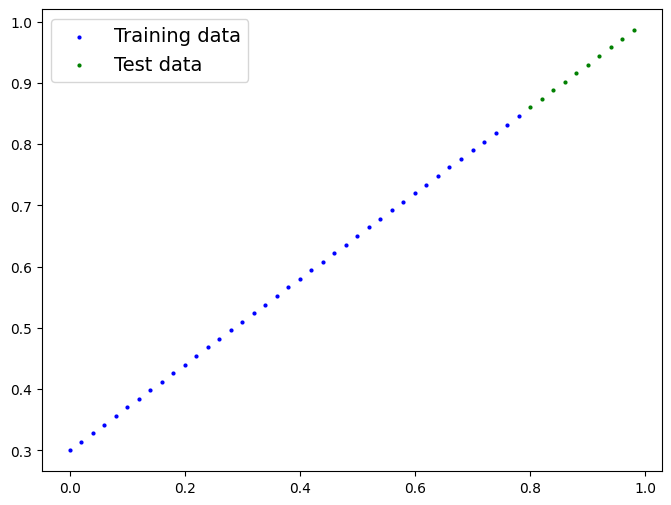

In [35]:
plot_predictions()

#### Build Model (Linear Regression)

In [36]:
# note : nn.Module is also an abstract class, so we need to overwrite the forward method

class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=float))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [37]:
torch.manual_seed(42)

model_0 = LinearRegression()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([0.1288], dtype=torch.float64, requires_grad=True)]

In [38]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367], dtype=torch.float64)),
             ('bias', tensor([0.1288], dtype=torch.float64))])

In [39]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [40]:
# turn off gradient tracking <-- useful when we're making predictions instead of training. It reduces gradient tracking memory since we dont need them when we're only predicting.
with torch.inference_mode():
    y_preds = model_0(X_test)

# we can also do this <-- however inference mode is preffered
with torch.no_grad():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], dtype=torch.float64)

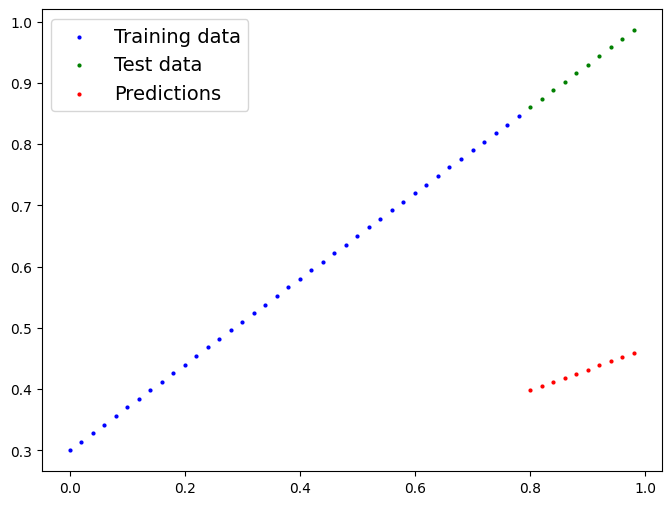

In [41]:
plot_predictions(predictions=y_preds)

#### Setting up a loss function for regression problem

In [42]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367], dtype=torch.float64)),
             ('bias', tensor([0.1288], dtype=torch.float64))])

In [43]:
# loss function
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [ ]:
torch.manual_seed(42)

# an epoch is a loop that goes thorugh our data
epochs = 200 # <-- this is our hyperparameter
epoch_count = []
loss_values = []
test_losses = []

for epoch in range(epochs):
    model_0.train() # train mode in pytorch, sets all requires grad params to be true
    
    # 1. forward pass
    y_pred = model_0(X_train)
    
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()
    
    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()    
    
    # Testing
    model_0.eval() # turns off gradient tracking
    with torch.inference_mode():
        # 1. do the foward pass
        test_pred = model_0(X_test)
        
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
        
    if epoch % 10 == 0:
        print(f"Epoch : {epoch} | Loss : {loss} | Test loss : {test_loss}")
        
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_losses.append(test_loss)
        
        print(model_0.state_dict())

Epoch : 0 | Loss : 0.31288135683755547 | Test loss : 0.4810651841540759
OrderedDict({'weights': tensor([0.3406], dtype=torch.float64), 'bias': tensor([0.1388], dtype=torch.float64)})
Epoch : 10 | Loss : 0.1976713574739093 | Test loss : 0.346355184508239
OrderedDict({'weights': tensor([0.3796], dtype=torch.float64), 'bias': tensor([0.2388], dtype=torch.float64)})
Epoch : 20 | Loss : 0.08908721056311557 | Test loss : 0.21729648486064157
OrderedDict({'weights': tensor([0.4184], dtype=torch.float64), 'bias': tensor([0.3333], dtype=torch.float64)})
Epoch : 30 | Loss : 0.05314849742260115 | Test loss : 0.14464008519991425
OrderedDict({'weights': tensor([0.4512], dtype=torch.float64), 'bias': tensor([0.3768], dtype=torch.float64)})
Epoch : 40 | Loss : 0.04543793101588776 | Test loss : 0.11360938544629148
OrderedDict({'weights': tensor([0.4748], dtype=torch.float64), 'bias': tensor([0.3868], dtype=torch.float64)})
Epoch : 50 | Loss : 0.041678606478126046 | Test loss : 0.09919938569279392
Order

In [45]:
weight, bias

(0.7, 0.3)

In [46]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

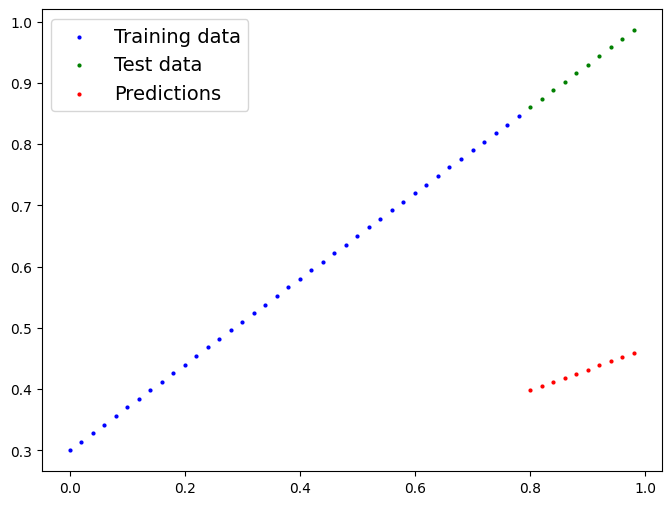

In [47]:
plot_predictions(predictions=y_preds)

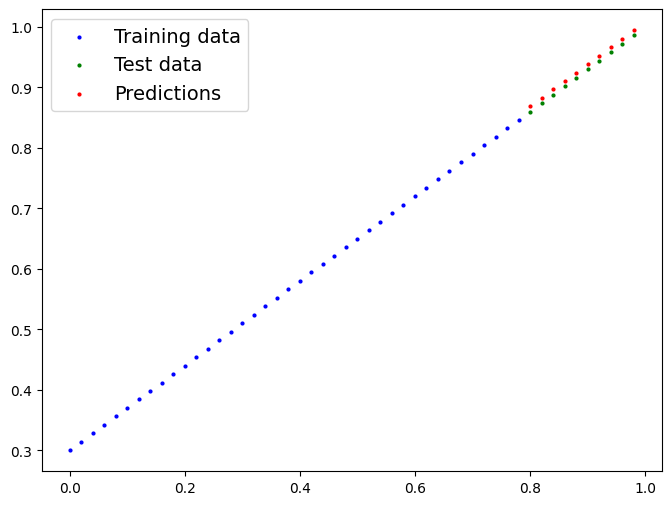

In [48]:
plot_predictions(predictions=y_preds_new)

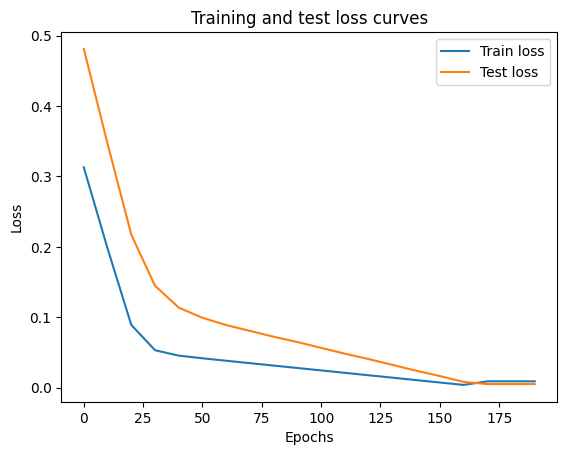

In [49]:
import numpy as np

  # note we need to add .cpu() if were using gpus tensors

# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label='Train loss')
plt.plot(epoch_count, test_losses, label='Test loss')
plt.title("Training and test loss curves")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

#### Saving our model

In [50]:
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path('../models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to : ..\models\01_pytorch_workflow_model_0.pth


#### Try to load our model (just the dict)

In [51]:
loaded_model = LinearRegression()

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model.state_dict()

OrderedDict([('weights', tensor([0.6990], dtype=torch.float64)),
             ('bias', tensor([0.3093], dtype=torch.float64))])

In [52]:
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)
    
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]], dtype=torch.float64)

In [57]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)
    
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]], dtype=torch.float64)

In [58]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [ ]:
next(model_0.parameters()).device

device(type='cpu')